Download raw photos:
```
cd ~/data/flowers
wget http://download.tensorflow.org/example_images/flower_photos.tgz
tar -xzvf flower_photos.tgz
```

In [1]:
from __future__ import division

import logging
import math
import matplotlib.pyplot as plt
import os
import os.path
import random
import tensorflow as tf

from xy_python_utils.os_utils import mkdir_p

from flowers_dataset import (
    get_dataset,
    write_label_file,
)

In [2]:
reload(logging)
logging.basicConfig(format = "[%(asctime)s] %(message)s",
                    datefmt = "%Y-%m-%d %H:%M:%S",
                    level = logging.INFO)

%matplotlib inline

slim = tf.contrib.slim
sess = tf.InteractiveSession()

In [3]:
base_dir = os.path.expanduser("~") + "/data/flowers"
photos_dir = base_dir + "/flower_photos"
tf_records_dir = base_dir + "/tf_records"
mkdir_p(tf_records_dir)

In [4]:
def get_filenames_and_classes(photos_dir):
    directories = []
    class_names = []
    for filename in os.listdir(photos_dir):
        path = os.path.join(photos_dir, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            path = os.path.join(directory, filename)
            photo_filenames.append(path)
            
    return photo_filenames, class_names


photo_filenames, class_names = get_filenames_and_classes(photos_dir)
class_name_to_id = dict(zip(class_names, xrange(len(class_names))))

In [5]:
# Split data into training and validation set.
random_seed = 0
num_validation = 350
random.seed(random_seed)
random.shuffle(photo_filenames)
validation_filenames = photo_filenames[:num_validation]
training_filenames = photo_filenames[num_validation:]

In [6]:
class ImageReader:
    def __init__(self):
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_jpeg(self, sess, image_data):
        image = sess.run(self._decode_jpeg, feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image

In [7]:
def get_dataset_filename(dataset_dir, split_name, shard_id, num_shards):
    output_filename = "flowers_%s_%05d-of-%05d.tfrecord" % (split_name, shard_id, num_shards)
    return os.path.join(dataset_dir, output_filename)


def bytes_feature(values):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value=[values]))


def int64_feature(values):
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def image_to_tfexample(image_data, image_format, height, width, class_id):
    return tf.train.Example(features = tf.train.Features(feature = {
                "image/encoded": bytes_feature(image_data),
                "image/format": bytes_feature(image_format),
                "image/class/label": int64_feature(class_id),
                "image/height": int64_feature(height),
                "image/width": int64_feature(width),                
            }))


def convert_dataset(split_name, filenames, class_names_to_id, dataset_dir, num_shards = 5):
    assert split_name in ("train", "validation")
    num_per_shard = int(math.ceil(len(filenames) / num_shards))
    image_reader = ImageReader()
    for shard_id in xrange(num_shards):
        logging.info("Processing %s, shard %d out of %d", split_name, shard_id, num_shards)
        output_filename = get_dataset_filename(dataset_dir, split_name, shard_id, num_shards)
        with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
            start_idx = shard_id * num_per_shard
            end_idx = min((shard_id+1) * num_per_shard, len(filenames))
            for idx in xrange(start_idx, end_idx):
                # Read the image data.
                image_data = tf.gfile.FastGFile(filenames[idx], 'r').read()
                height, width = image_reader.read_image_dims(sess, image_data)
                # Read class name from folder path.
                class_name = os.path.basename(os.path.dirname(filenames[idx]))
                class_id = class_names_to_id[class_name]
                # Create an example and serialize to disk.
                example = image_to_tfexample(image_data, "jpg", height, width, class_id)
                tfrecord_writer.write(example.SerializeToString())
                    
                    
convert_dataset("train", training_filenames, class_name_to_id, tf_records_dir)
convert_dataset("validation", training_filenames, class_name_to_id, tf_records_dir)
write_label_file(class_names, tf_records_dir + "/labels.txt")

[2016-10-25 15:01:55] Processing train, shard 0 out of 5
[2016-10-25 15:01:58] Processing train, shard 1 out of 5
[2016-10-25 15:02:00] Processing train, shard 2 out of 5
[2016-10-25 15:02:02] Processing train, shard 3 out of 5
[2016-10-25 15:02:05] Processing train, shard 4 out of 5
[2016-10-25 15:02:07] Processing validation, shard 0 out of 5
[2016-10-25 15:02:09] Processing validation, shard 1 out of 5
[2016-10-25 15:02:12] Processing validation, shard 2 out of 5
[2016-10-25 15:02:14] Processing validation, shard 3 out of 5
[2016-10-25 15:02:16] Processing validation, shard 4 out of 5


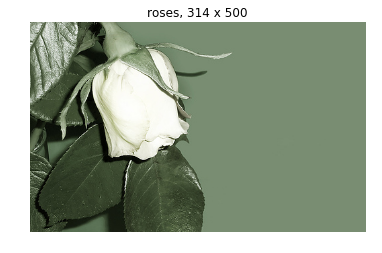

In [8]:
dataset = get_dataset("train", tf_records_dir)
data_provider = slim.dataset_data_provider.DatasetDataProvider(dataset, common_queue_capacity=32, common_queue_min=1)
image, label = data_provider.get(["image", "label"])
with slim.queues.QueueRunners(sess):
    np_image, np_label = sess.run([image, label])
    height, width, _ = np_image.shape
    class_name = dataset.labels_to_names[np_label]
    
    plt.figure()
    plt.imshow(np_image)
    plt.title("%s, %d x %d" % (class_name, height, width))
    plt.axis("off")